In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
training_set = pd.read_csv("../input/train.csv")
test_set = pd.read_csv("../input/test.csv")
sample_set = pd.read_csv("../input/sample_submission.csv")

In [3]:
real_test_set = test_set.iloc[:,1:].values

In [4]:
X = training_set.iloc[:,2:].values
y = training_set.iloc[:,1].values

In [5]:
# new_X = (X - np.min(X)) / (np.max(X) - np.min(X))
# new_X
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# # Feature extraction
# test = SelectKBest(score_func=chi2, k=150)
# fit = test.fit(new_X, y)

# # Summarize scores
# np.set_printoptions(precision=3)
# print(fit.scores_)

# features = fit.transform(new_X)
# X = features
# # Summarize selected features
# print(features[0:5,:])

In [6]:
# ### see adjusted r squared
# import statsmodels.api as sm
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()
# x = model.summary()
# x.as_csv

In [7]:
# split into training, validation and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [8]:
# apply feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)
real_test_set = sc.transform(real_test_set)

In [9]:
# # Applying PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 140)
# # X_train = X_train.dropna(inplace=True)
# X_train = pca.fit_transform(X_train) #pca is unsupervised, so we don't fit y_train here
# X_val = pca.transform(X_val)
# X_test = pca.transform(X_test)
# # real_test_set = pca.transform(real_test_set)

In [10]:
# # Fitting XGBoost to the Training set
# from xgboost import XGBClassifier
# classifier = XGBClassifier(n_jobs=-1, verbosity=3)
# classifier.fit(X_train, y_train)

In [11]:
# Applying light gbm model
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
# params['lambda_l1'] = 0.03
params['lambda_l2'] = 0.05
params['num_leaves'] = 50
params['min_data'] = 50
params['max_depth'] = 15
# params['max_bin'] = 255
classifier = lgb.train(params, d_train, 700)

In [12]:
# # Applying light gbm model from sklearn
# import lightgbm as lgbm
# # from lightgbm import LGBMClassifier
# classifier = lgbm.LGBMClassifier(
#     learning_rate=0.1,
#     boosting_type='gbdt', 
#     objective='binary',
#     metric='binary_logloss',
#     sub_feature=0.5,
#     reg_alpha=0.1,
#     reg_lambda=0.1,
#     num_leaves=50,
#     min_data=50,
#     max_depth=15,
#     num_estimators=400
# )
# classifier.fit(X_train, y_train)

In [13]:
# # Grid search using lgb
# # # Tuning the ANN
# from sklearn.model_selection import GridSearchCV
# parameters = [{'metric': ['binary_logloss'], 'num_leaves': [40], 'min_data': [40]},
#                {'metric': ['binary_logloss'], 'num_leaves': [50], 'min_data': [50]},
#                {'metric': ['binary_logloss'], 'num_leaves': [60], 'min_data': [60]},
#                {'metric': ['binary_logloss'], 'num_leaves': [70], 'min_data': [70]}, ]
# grid_search = GridSearchCV(estimator = classifier,
#                            param_grid = parameters,
#                            scoring = ['accuracy', 'roc_auc'],
#                            cv = 3,
#                            verbose = 10)
# grid_search.fit(X_train, y_train)

# # best_parameters = grid_search.best_params_
# # best_accuracy = grid_search.best_score_
# # (best_parameters, best_accuracy)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### *using validation set*


In [14]:
# using validation set
val_pred = classifier.predict(X_val)
# area under the curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# val_cm = confusion_matrix(y_val, val_pred)
val_a_uc = roc_auc_score(y_val, val_pred)
# (val_a_uc, val_cm)
val_a_uc

0.8851237975969695

In [15]:
# # Plotting the area under the curve with validation set
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, thresholds = roc_curve(y_val, val_pred)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.plot(fpr, tpr, color='darkorange', lw=lw, marker='o', label='ROC curve (area = %0.2f)' % roc_auc)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()

### using test set

In [16]:
# # using test set
# y_pred = classifier.predict(X_test)
# test_cm = confusion_matrix(y_test, y_pred)
# test_a_uc = roc_auc_score(y_test, y_pred)
# (test_a_uc, test_cm)

In [17]:
# # Plotting the area under the curve with test set
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.plot(fpr, tpr, color='darkorange', lw=lw, marker='o', label='ROC curve (area = %0.2f)' % roc_auc)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()

In [18]:
# real_pred = classifier.predict(real_test_set)
# id_codes = []
# for i in range(0, 200000):
#     key = 'test_' + str(i)
#     id_codes.append(key)
# predictions = np.reshape(real_pred, (-1, 1))
# predictions = np.insert(predictions, 0, values=3, axis=1)
# predictions_df = pd.DataFrame(predictions, index=np.arange(1,200001), columns=['ID_code', 'target'])
# predictions_df["ID_code"] = id_codes
# predictions_df.to_csv('submission.csv', index=False)
# # predictions_df

In [19]:
# results of confusion matrix
# Decision tree = 0.8366875
# Random forest: val_set = 0.89971875, test_set = 0.899925
# Xgboost: val_set = 0.9010625

# results of roc
# xgboost_val =  0.5076391594720207
# xgboost_test = 0.5091621607483905
# lightgbm: val: 0.8610609924277948

In [20]:
# Applying k-Fold Cross Validation
# from sklearn.model_selection import cross_val_score
# accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, verbose = 3, n_jobs = -1, scoring='roc_auc')
# accuracies.mean()
# accuracies.std()

## Apply an artificial neural network

In [21]:
# # Importing the Keras libraries and packages
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras import regularizers

# # Initialising the ANN
# classifier = Sequential()

# # Adding the input layer and the first hidden layer
# classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), input_dim = 200))
# #classifier.add(Dropout(0.2))

# # Adding the second hidden layer
# classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# #classifier.add(Dropout(0.2))
# # classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))

# # Adding the third hidden layer
# classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# #classifier.add(Dropout(0.2))

# # Adding the output layer
# classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [22]:
# # import tensorflow as tf
# # from sklearn.metrics import roc_auc_score
# # def auroc(y_true, y_pred):
#     # return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

# # Compiling the ANN
# from keras import optimizers
# adam = optimizers.Adam(lr=0.0083, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# # Fit the ANN
# classifier.fit(X_train, y_train, batch_size = 50, epochs = 30, verbose = 2)

## Tuning the ann

In [23]:
# # Tuning the ANN
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras import regularizers
# import multiprocessing
# from sklearn.externals.joblib import parallel_backend
# from time import sleep
# from joblib import Parallel, delayed
# def build_classifier(optimizer):
#     classifier = Sequential()
#     classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), input_dim = 200))
#     classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
#     classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
#     classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
#     classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
#     return classifier
# classifier = KerasClassifier(build_fn = build_classifier)
# parameters = {'batch_size': [40, 50, 100],
#               'epochs': [30, 50, 80],
#               'optimizer': ['adam', 'rmsprop']}
# grid_search = GridSearchCV(estimator = classifier,
#                            param_grid = parameters,
#                            scoring = 'accuracy',
#                            cv = 3,
# #                            n_jobs = 1,
#                            verbose = 10)
# # with parallel_backend('multiprocessing'):
# #     grid_search.fit(X_train, y_train)
# # Parallel(n_jobs=3, backend="multiprocessing")(delayed(grid_search.fit(X_train, y_train)))
# # grid_result = grid_search.fit(X_train, y_train)
# grid_search.fit(X_train, y_train)

# # best_parameters = grid_search.best_params_
# # best_accuracy = grid_search.best_score_
# # (best_parameters, best_accuracy)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

## Cross-validation

In [24]:
# # cross validate ANN
# from keras.wrappers.scikit_learn import KerasClassifier
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras import regularizers
# from sklearn.model_selection import cross_val_score
# def build_classifier():
#     classifier = Sequential()
#     classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), input_dim = 200))
#     classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
#     classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
#     classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
#     classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#     return classifier

# classifier = KerasClassifier(build_fn = build_classifier, batch_size=100, epochs = 30)
# accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 3, verbose=2)
# mean = accuracies.mean()
# variance = accuracies.std()

## Predictions

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# Predicting the validation set results
val_pred = classifier.predict(X_val)
val_pred = np.reshape(val_pred, 32000)
# val_pred = np.around(val_pred, decimals=-2).astype(int)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
# val_cm = confusion_matrix(y_val, val_pred)
val_a_uc = roc_auc_score(y_val, val_pred)
# (val_a_uc, val_cm)
val_a_uc

0.8851237975969695

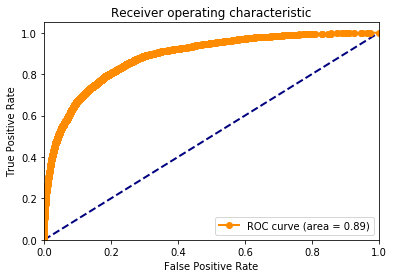

In [26]:
# Plotting the area under the curve with validation set
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, val_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr, tpr, color='darkorange', lw=lw, marker='o', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
# Predicting the test set results
y_pred = classifier.predict(X_test)
y_pred = np.reshape(y_pred, 40000)
# y_pred = np.around(y_pred, decimals=-2).astype(int)
# Making the Confusion Matrix
# test_cm = confusion_matrix(y_test, y_pred)
test_a_uc = roc_auc_score(y_test, y_pred)
# (test_a_uc, test_cm)
test_a_uc

0.8806019716298352

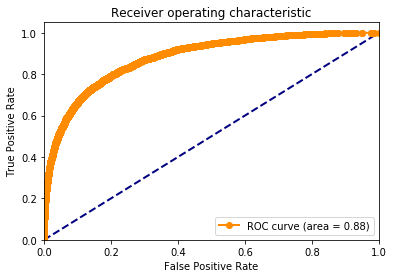

In [28]:
# Plotting the area under the curve with test set
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr, tpr, color='darkorange', lw=lw, marker='o', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
# using adam
# using dropout of 0.2
# val: 0.8219703092136943
# test: 0.8184382643851061
# using l2 regularization of 
# (0.001 val: 0.8514070212752984), (0.002 val: 0.8522397124920501)
# using l2 and l1 regularization
# val: 0.8523018854700104, using 100epochs: 0.8519824055995491
# b:40,e:30 val:0.849410565838969
# b:40,e:50 val:0.8524478473924889
# b:40,e:80 val:0.8527870805309873
# b:50,e:50 val:0.8529468069291648
# b:100,e:30 val:0.852986280976311







# (of li:0.001, l2: 0.002, val: 0.8510900592967333)

# using rmsprop
# val: 0.8067250585832222
# test: 0.8038354740235442

In [30]:
real_pred = classifier.predict(real_test_set)
# real_pred = real_pred = np.around(real_pred, decimals=-2).astype(int)
id_codes = []
for i in range(0, 200000):
    key = 'test_' + str(i)
    id_codes.append(key)
predictions = np.reshape(real_pred, (-1, 1))
predictions = np.insert(predictions, 0, values=3, axis=1)
predictions_df = pd.DataFrame(predictions, index=np.arange(1,200001), columns=['ID_code', 'target'])
predictions_df["ID_code"] = id_codes
predictions_df.to_csv('submission.csv', index=False)
# predictions_df

## saving the model

In [31]:
# filename = "binary_classifier_model.sav"
# from sklearn.externals import joblib
# # save the model to disk
# joblib.dump(classifier, filename)
# # load the model from disk
# loaded_model = joblib.load(filename)